# Analyzing PLS Stability

This notebook tries to explore the influence of temporal data skewness on PLS. 


1. **PLSDA-Batch**: Inspired by [PLSDA-Batch](https://doi.org/10.1093/bib/bbac622) uses pRDA to investigate how much explainable variance comes from party affiliations vs temporal difference of the speeches, here we also implement PLSDA-Batch method to remove temporal variance from the data.

2. **Leave-one-year-out validation / Bootstrapping**: In order to assess how robust PLS is against temporal difference we employ LOOV and bootstrapping, measuring F1 micro score on validation folds, computing angle between reference PLS space found on the whole data and ones identified on different validation sets.


In [1]:
import os
if not os.environ.get("PREAMBLE_RUN", False): 
    %run -i 'preamble.py'

In [2]:
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from src.constants import COLOR_MAPS, PATH_VOCAB_EMBEDDED, EMBEDDING_MODEL, PATH_MIGRATION_SPEECHES_EMBEDDED
from src.dim_reduction import display_axis_semantics, closest_words_for_pc, get_extreme_examples, get_aggregated_embeddings_for_each_year

In [3]:
df = pd.read_parquet(PATH_MIGRATION_SPEECHES_EMBEDDED)
print(f"#Samples: {len(df)}")

#Samples: 9705


In [4]:
df = df[~df['written']]

In [5]:
vocab_df = pd.read_parquet(PATH_VOCAB_EMBEDDED)

# Removing temporal variance



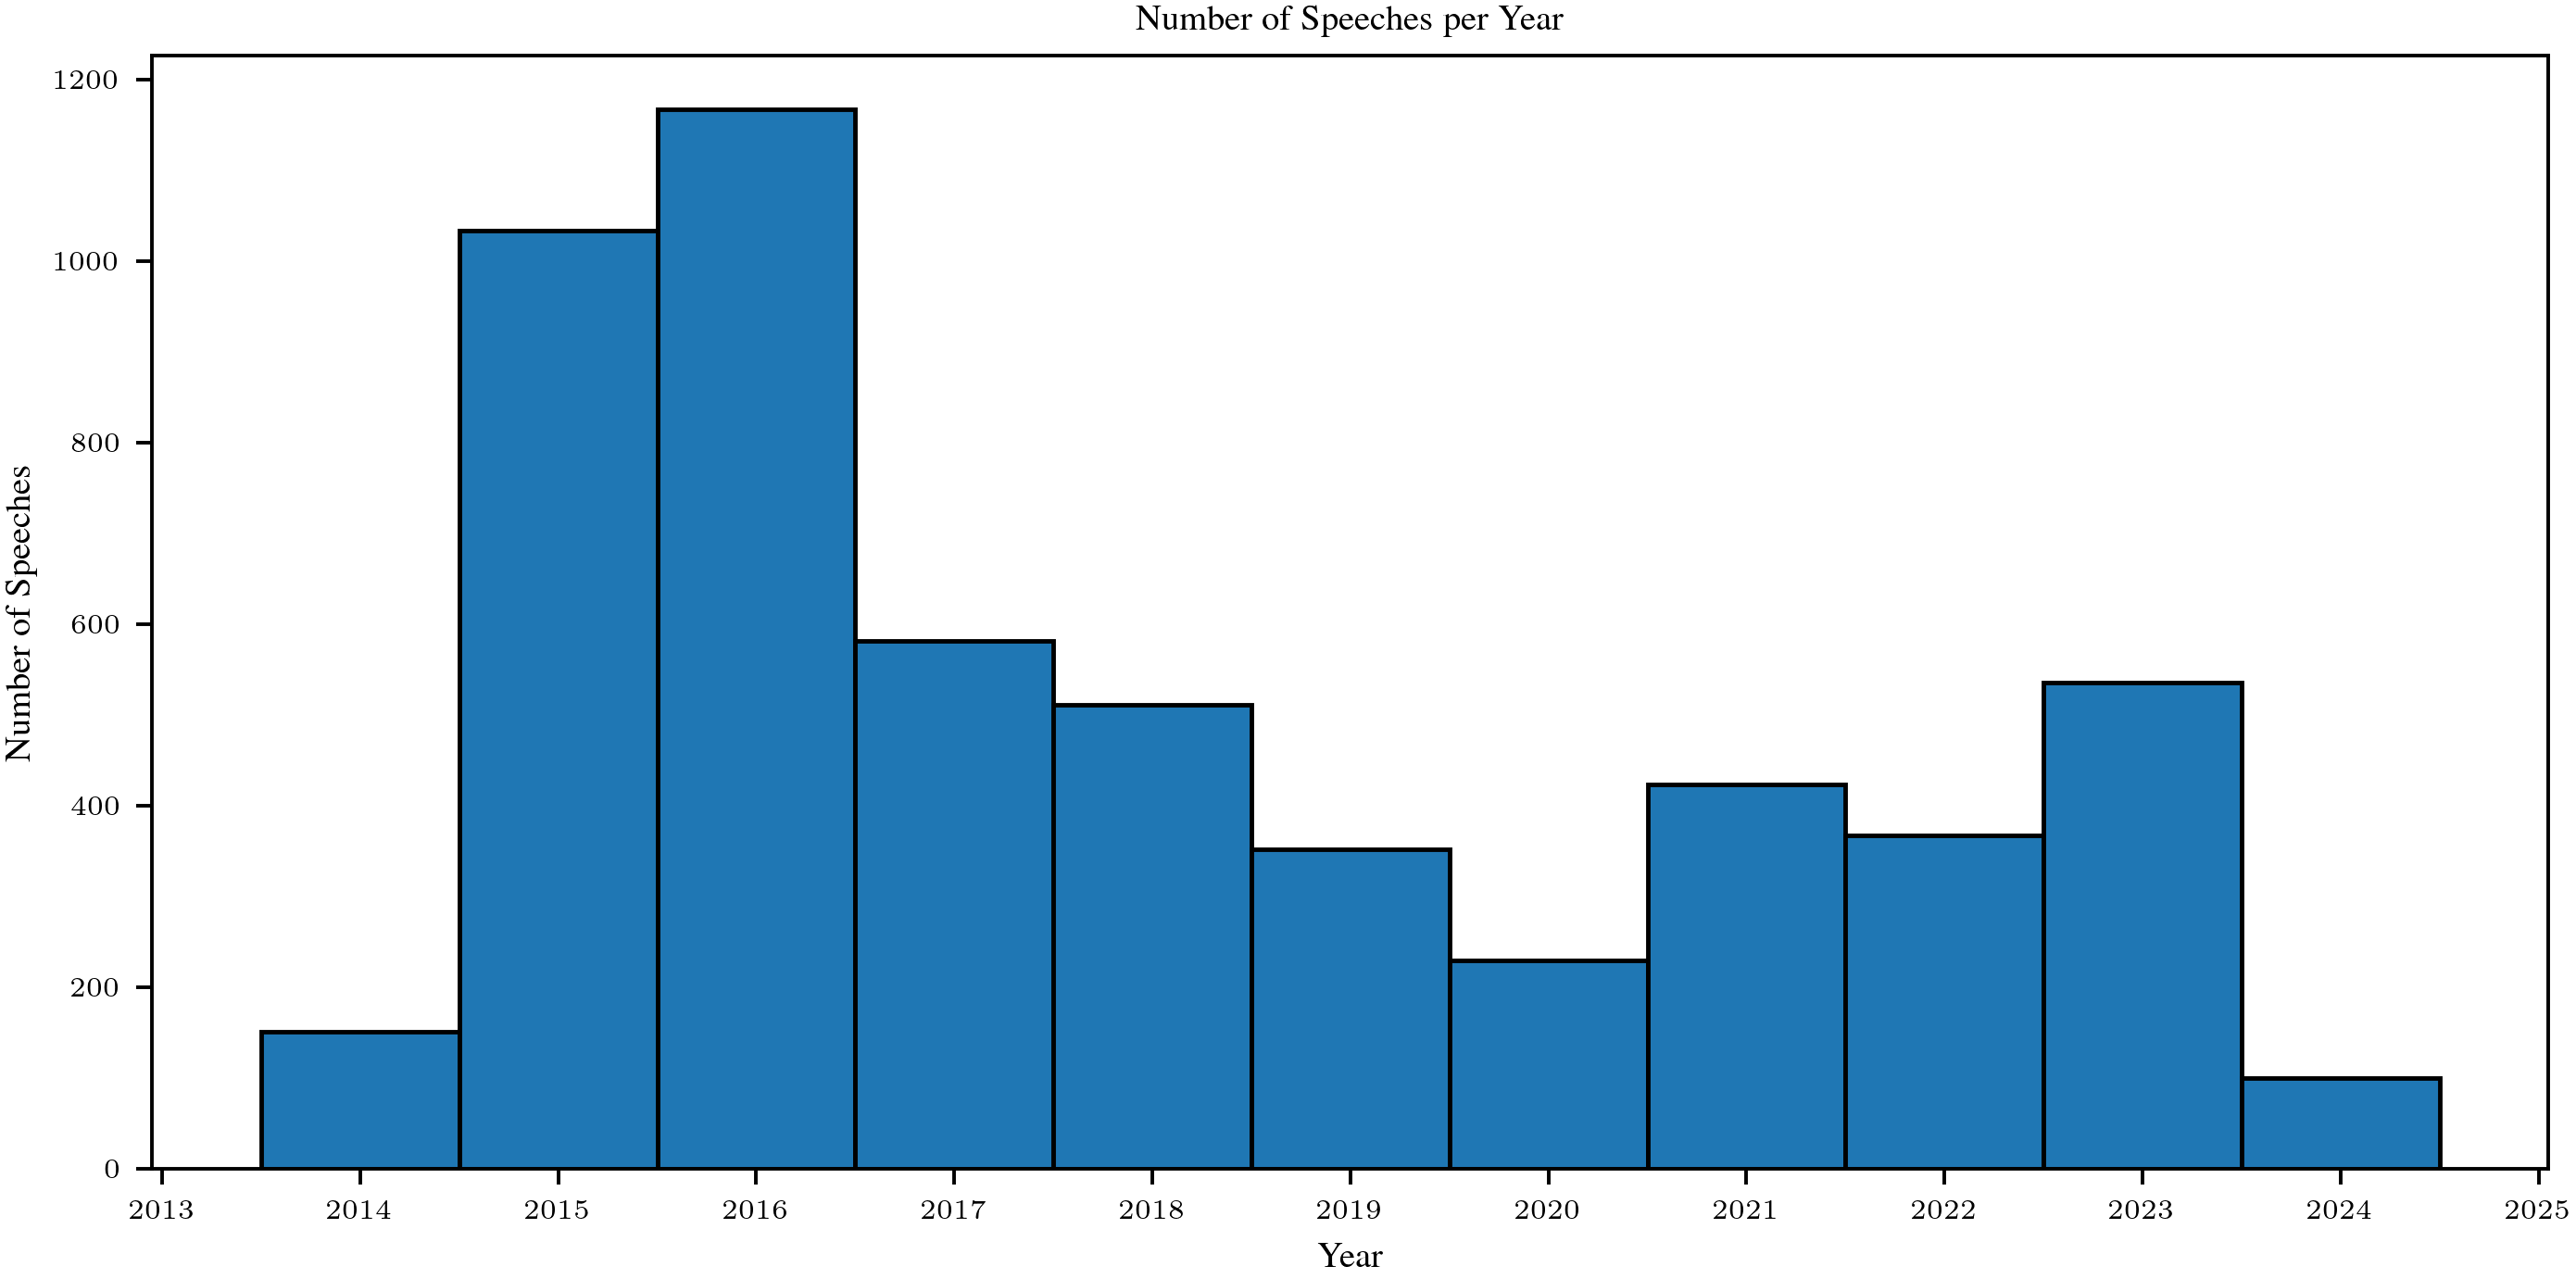

In [6]:
# histogram of dominant topics
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot()
ax.set_title("Number of Speeches per Year")
ax.hist(pd.to_datetime(df['date']).dt.year.sort_values(), bins=np.arange(2013.5, 2025.5, 1), edgecolor='black')

ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Number of Speeches')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()

We have substantially more data in 2015-2016 years which might be skewing our PLS-DA results

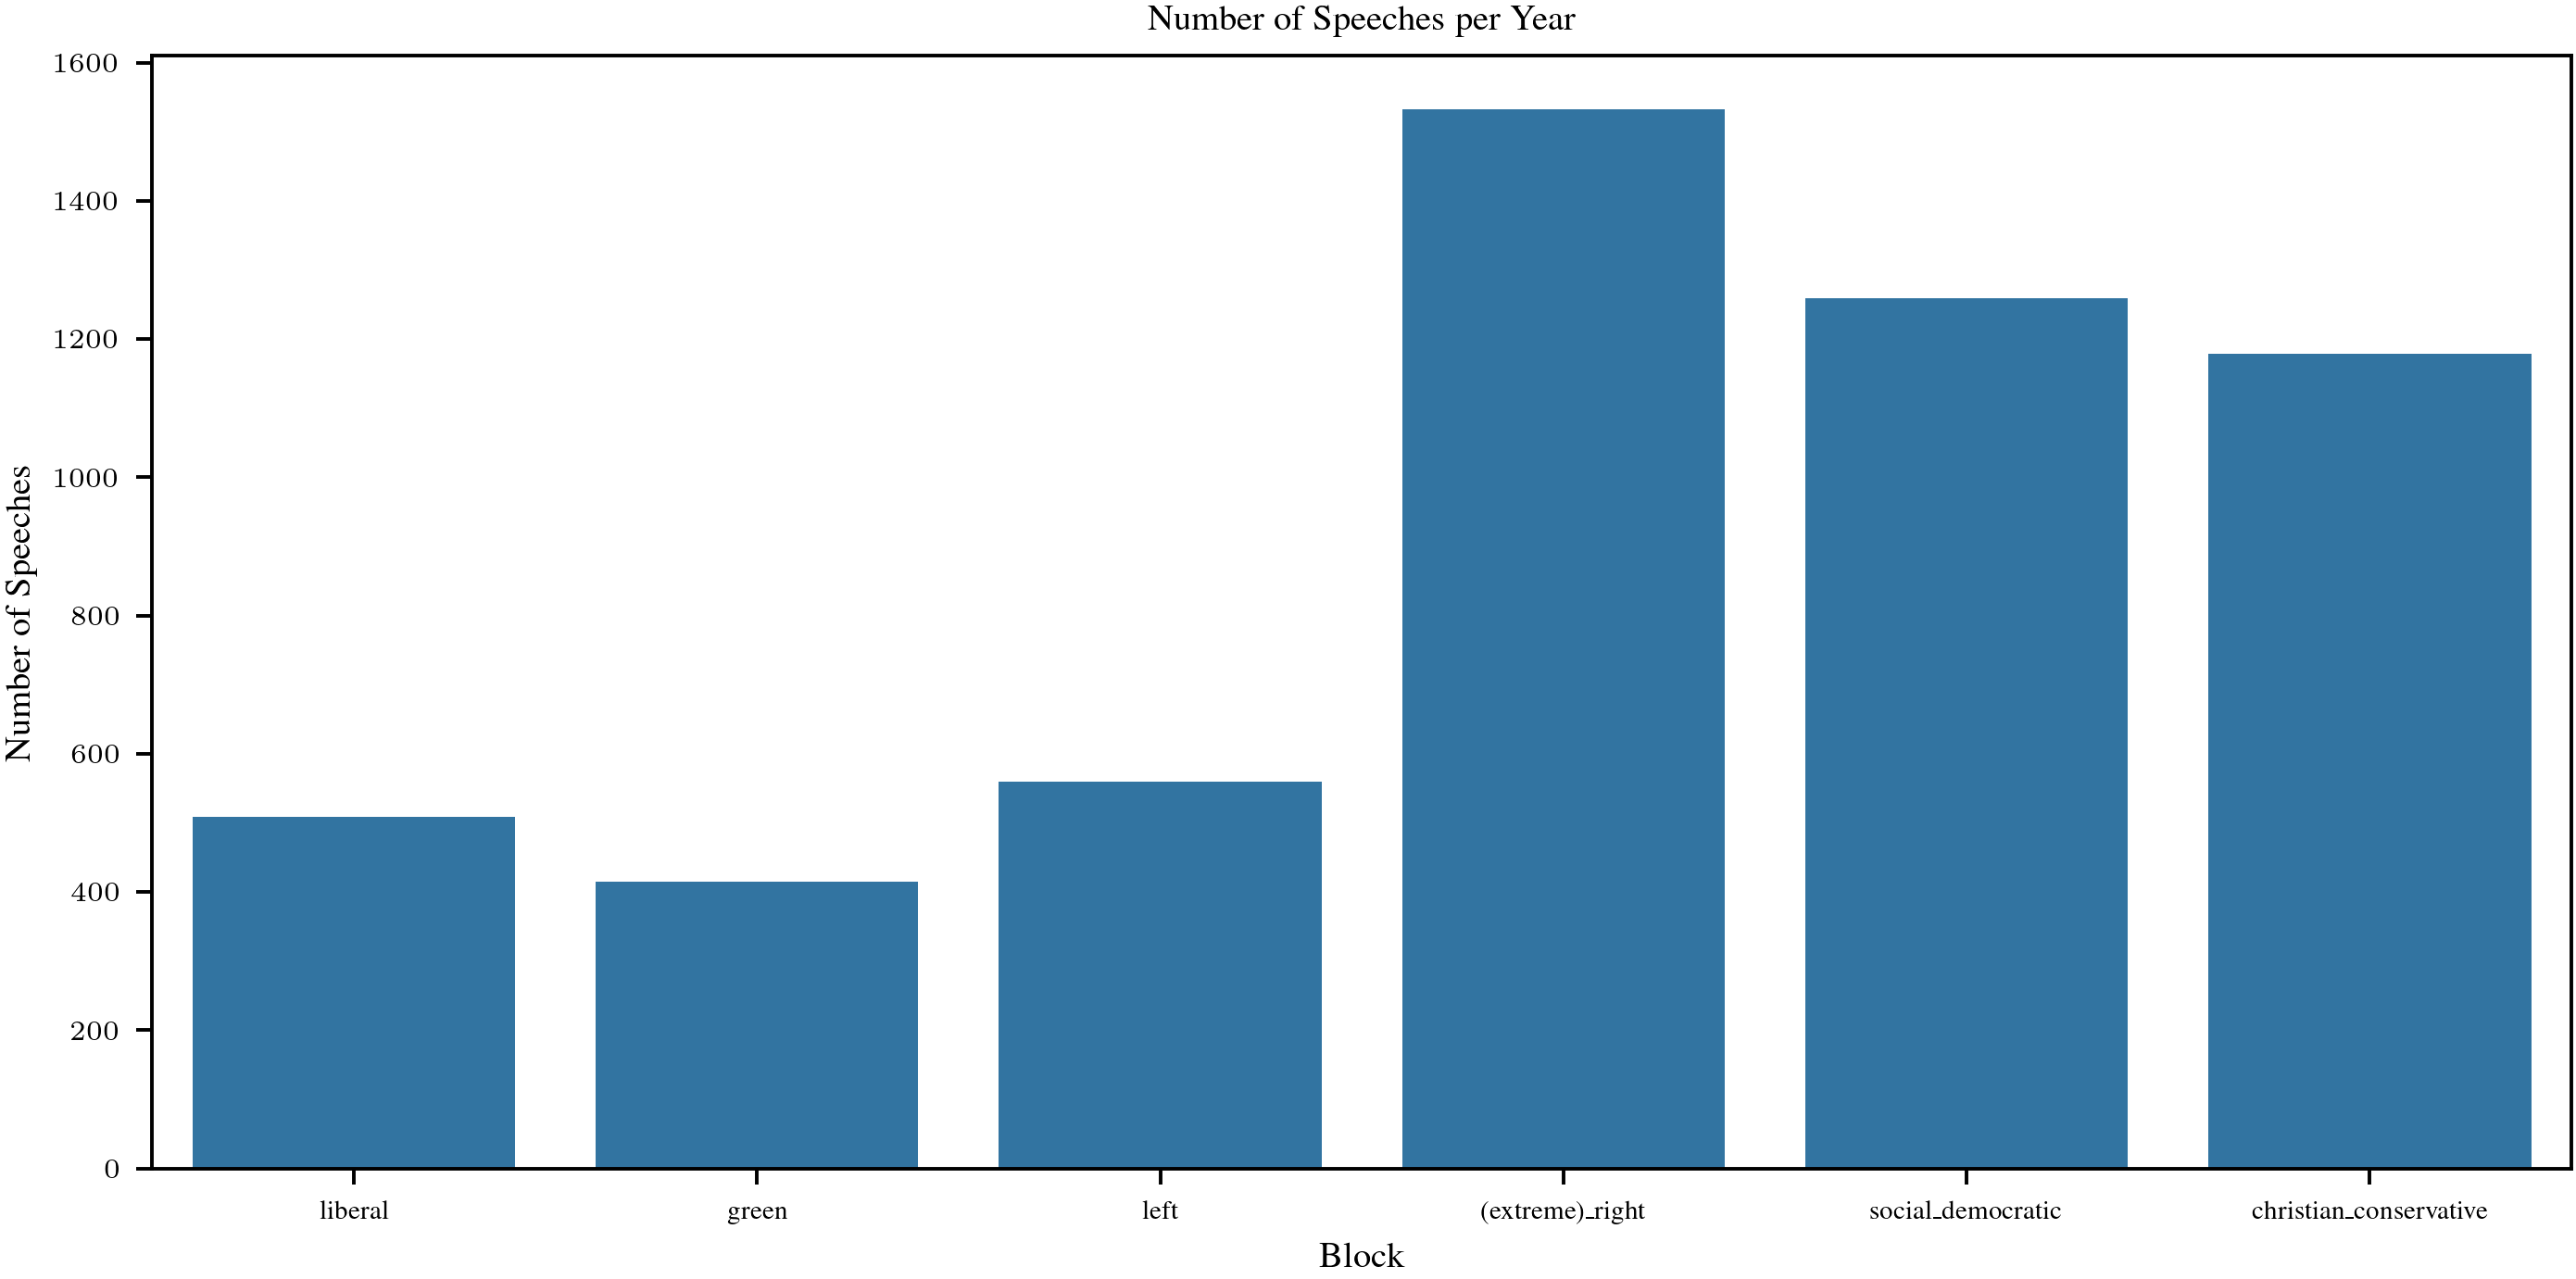

In [7]:
# histogram of dominant topics
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot()
ax.set_title("Number of Speeches per Year")
sns.countplot(data=df, x='block', ax=ax)
# ax.hist(df['block'], bins=list(df['block'].unique()), edgecolor='black')

ax.xaxis.set_label_text('Block')
ax.yaxis.set_label_text('Number of Speeches')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.show()

## Partial Redundancy Analysis

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder


X = np.stack(df[EMBEDDING_MODEL])

lb_year = LabelEncoder().fit(df['year'])
year_y = np.eye(len(lb_year.classes_))[lb_year.transform(df['year'])]

lb_block = LabelEncoder().fit(df['block'])
block_y = np.eye(len(lb_block.classes_))[lb_block.transform(df['block'])]


block_year_y = np.concat([year_y, block_y], axis=1)

model_year =  LinearRegression().fit(year_y, X)
model_block = LinearRegression().fit(block_y, X)
r2_year = model_year.score(year_y, X)
r2_block = model_block.score(block_y, X)
r2_party_year = LinearRegression().fit(block_year_y, X).score(block_year_y, X)


X_res_year = X - model_year.predict(year_y)
X_res_block = X - model_block.predict(block_y)

r2_only_year =  LinearRegression().fit(year_y, X_res_block).score(year_y, X_res_block)
r2_only_block =  LinearRegression().fit(block_y, X_res_year).score(block_y, X_res_year)

shared = r2_party_year - r2_only_year - r2_only_block
residual = 1 - r2_party_year

In [9]:
explainable_variance = pd.DataFrame([{"residual": residual, "intersection": r2_party_year, "block": r2_only_block, "year": r2_only_year}])

Text(0, 0.5, 'Explainable variance %')

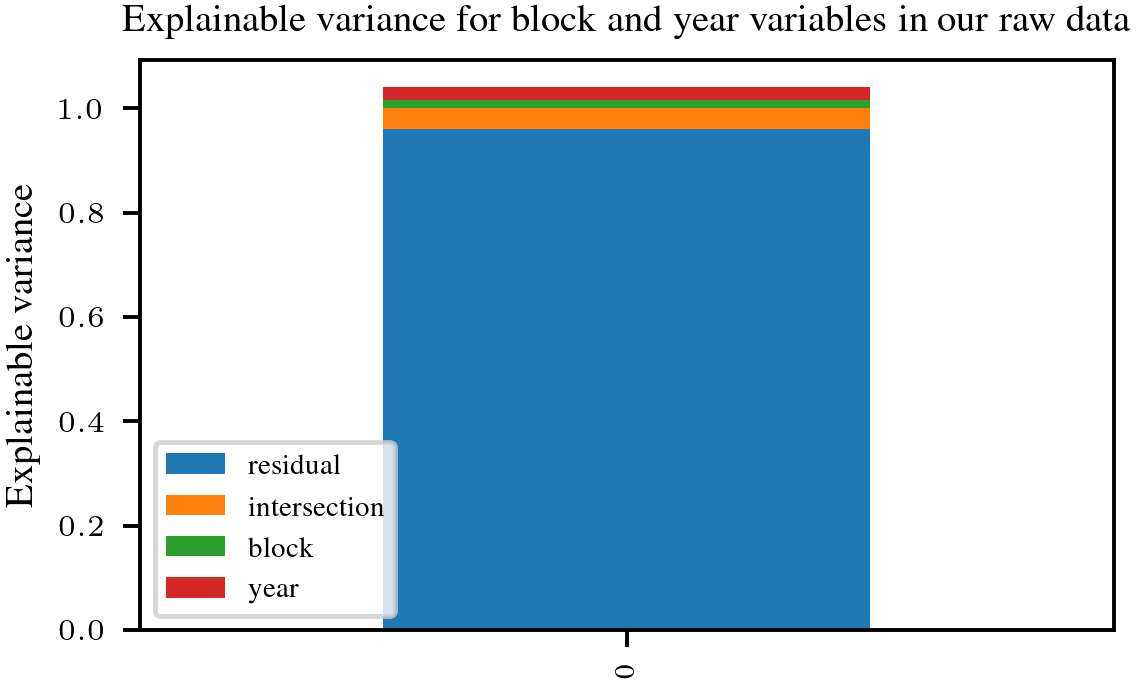

In [10]:
explainable_variance.plot(kind="bar", stacked=True)
plt.title("Explainable variance for block and year variables in our raw data")
plt.ylabel("Explainable variance %")

In [11]:
def pra(X: np.array):

    lb_year = LabelEncoder().fit(df['year'])
    year_y = np.eye(len(lb_year.classes_))[lb_year.transform(df['year'])]

    lb_block = LabelEncoder().fit(df['block'])
    block_y = np.eye(len(lb_block.classes_))[lb_block.transform(df['block'])]


    block_year_y = np.concat([year_y, block_y], axis=1)

    model_year =  LinearRegression().fit(year_y, X)
    model_block = LinearRegression().fit(block_y, X)
    r2_year = model_year.score(year_y, X)
    r2_block = model_block.score(block_y, X)
    r2_party_year = LinearRegression().fit(block_year_y, X).score(block_year_y, X)


    X_res_year = X - model_year.predict(year_y)
    X_res_block = X - model_block.predict(block_y)

    r2_only_year =  LinearRegression().fit(year_y, X_res_block).score(year_y, X_res_block)
    r2_only_block =  LinearRegression().fit(block_y, X_res_year).score(block_y, X_res_year)

    shared = r2_party_year - r2_only_year - r2_only_block
    residual = 1 - r2_party_year

    return r2_year, r2_block, r2_only_year, r2_only_block, shared, residual

Explainable variance coming from intersection of block and year variable is very high so we can assume that a year plains a substantial role in finding PLS axis

## PLSDA-Batch
Method for removing batch variance from the data. batch in our case is the year variable

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import PLSRegression


def plsda(X: np.array, y: pd.Series, n_components: int = 2) -> np.array:

    lb = LabelEncoder()
    y = lb.fit_transform(y)

    y = np.eye(len(lb.classes_))[y]  # create one-hot encodding to use PLS for classification PLS-DA


    pls = PLSRegression(n_components=n_components)
    pls.fit(X, y)
    return pls.x_loadings_, (pls, lb)


def deflation(X: np.array, A: np.array) -> np.array: 
    # deflation of X on latent dimensions A 
    d, n = A.shape 
    for idx in range(n): 
        a = A[:, idx][:, np.newaxis] 
        t = X @ a # projection of X 
        y = np.linalg.inv(t.T @ t) @ t.T @ X # regression coefficient 
        X = X - t @ y 
    return X



X = np.stack(df[EMBEDDING_MODEL])
A_block, _ = plsda(X, df['block'])
X_no_block = deflation(X, A_block)
A_year, _ = plsda(X_no_block, df['year'])

X_no_year = deflation(X, A_year)


In [13]:
variance = []
r2_year, r2_block, r2_only_year, r2_only_block, shared, residual = pra(X)
variance.append({"data": "raw", "residual": residual, "intersection": shared, "block": r2_only_block, "year": r2_only_year})
r2_year, r2_block, r2_only_year, r2_only_block, shared, residual = pra(X_no_year)
variance.append({"data": "PLSDA-BATCH", "residual": residual, "intersection": shared, "block": r2_only_block, "year": r2_only_year})
r2_year, r2_block, r2_only_year, r2_only_block, shared, residual = pra(X - X_no_block)
variance.append({"data": "PLSDA - Block", "residual": residual, "intersection": shared, "block": r2_only_block, "year": r2_only_year})

Text(0, 0.5, 'Explainable variance %')

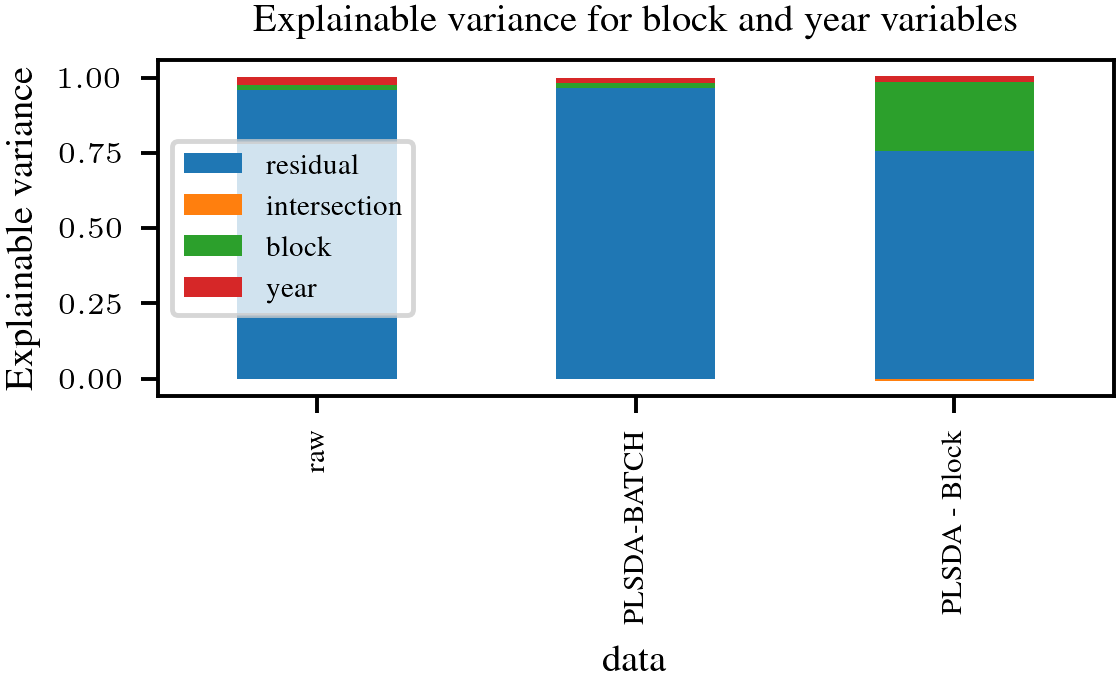

In [14]:
explainable_variance = pd.DataFrame(variance)
explainable_variance.set_index("data").plot(kind="bar", stacked=True)
plt.title("Explainable variance for block and year variables")
plt.ylabel("Explainable variance %")

After doing PLSDA we can observe that a lot more variance in our data is from block affiliations, so even though influence of year is still present they are not as dominant.

In [15]:
explainable_variance

,data,residual,intersection,block,year
0,raw,0.960227,0.039773,0.015674,0.024529
1,PLSDA-BATCH,0.965763,0.039773,0.016101,0.018344
2,PLSDA - Block,0.755983,0.039773,0.230674,0.019923


# Measuring robustneess of PLS-DA against skewness in our data

## Leave one year out validation

In [16]:
from scipy.linalg import orthogonal_procrustes


def align_vectors(variation, reference):
    R, _ = orthogonal_procrustes(variation, reference)
    return variation @ R


In [17]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score
from scipy.linalg import subspace_angles

aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

X = np.stack(df[EMBEDDING_MODEL])

W_whole, (pls_ref, _) = plsda(X, df['block'])

reduced_ref = pls_ref.transform(np.stack(df[EMBEDDING_MODEL]))

logo = LeaveOneGroupOut()
print(f"#Splits {logo.get_n_splits(X, df['block'], df['year'])}")

angles = []
f1_scores = []
mapped_centers = []


for i, (train_index, test_index) in enumerate(logo.split(X,  df['block'], df['year'])):
    held_out_year = list(df.iloc[test_index]['year'].unique())[0]
    print(f"Held out year: {held_out_year}")
    X_sub = X[train_index]
    y_sub = df.iloc[train_index]['block']
    W_sub, (pls, lb) = plsda(X_sub, y_sub)

    X_test = X[test_index]
    y_test = lb.transform(df.iloc[test_index]['block'])

    y_pred = pls.predict(X_test).argmax(axis=-1)
    f1_micro = f1_score(y_test, y_pred, average='micro')
    total_angle = sum(np.rad2deg(subspace_angles(W_whole, W_sub)))
    print(f" F1 score: {f1_micro}")

    print(total_angle)

    reduced_sub = pls.transform(np.stack(df[EMBEDDING_MODEL]))
    mapped_centers.append(align_vectors(reduced_sub, reduced_ref))

    angles.append(total_angle)
    f1_scores.append(f1_micro)


#Splits 11
Held out year: 2014
 F1 score: 0.4105960264900662
2.95414436787743
Held out year: 2015
 F1 score: 0.4206963249516441
13.359965605548833
Held out year: 2016
 F1 score: 0.4195205479452055
11.8391285314207
Held out year: 2017
 F1 score: 0.4845360824742268
7.519587520884096
Held out year: 2018
 F1 score: 0.46771037181996084
7.5603739218984884
Held out year: 2019
 F1 score: 0.4943181818181818
5.856730013370343
Held out year: 2020
 F1 score: 0.4192139737991266
4.024359959191617
Held out year: 2021
 F1 score: 0.491725768321513
6.974780592071793
Held out year: 2022
 F1 score: 0.40599455040871935
9.145985535491615
Held out year: 2023
 F1 score: 0.4701492537313433
9.70295463129575
Held out year: 2024
 F1 score: 0.5
2.5245981501788375


In [18]:
total_angle = np.array(total_angle)
f1_scores = np.array(f1_scores)

In [19]:
total_angle.mean(), f1_scores.std()

(np.float64(2.5245981501788375), np.float64(0.035972471306527816))

In [20]:
f1_scores.mean(), f1_scores.std()

(np.float64(0.4531328256145443), np.float64(0.035972471306527816))

In [21]:
plotting_data = df[['block', 'year']].copy()

In [ ]:
plotting_data['reduced_0'] = reduced_ref[:, 0]
plotting_data['reduced_1'] = reduced_ref[:, 1]
plotting_data

,block,year,reduced_0,reduced_1
492,liberal,2024,-1.893487,1.716269
844,green,2024,2.394027,-9.017150
1050,left,2024,1.889418,-0.779703
1054,(extreme)_right,2024,-0.493943,-1.050877
1056,(extreme)_right,2024,4.139432,1.276210
...,...,...,...,...
290792,(extreme)_right,2014,1.744711,-2.063310
291190,(extreme)_right,2014,0.698438,1.216518
291861,(extreme)_right,2014,1.831882,4.107945
292003,(extreme)_right,2014,1.581076,-6.432236


In [ ]:
combined = plotting_data.copy()

In [ ]:
for year, embs in zip(range(2014, 2025), mapped_centers):
    coppied = plotting_data.copy()
    coppied[f'reduced_0'] = embs[:, 0]
    coppied[f'reduced_1'] = embs[:, 1]
    combined =  pd.concat([combined, coppied])

In [ ]:
combined

,block,year,reduced_0,reduced_1
492,liberal,2024,-1.893487,1.716269
844,green,2024,2.394027,-9.017150
1050,left,2024,1.889418,-0.779703
1054,(extreme)_right,2024,-0.493943,-1.050877
1056,(extreme)_right,2024,4.139432,1.276210
...,...,...,...,...
290792,(extreme)_right,2014,1.721876,-2.114513
291190,(extreme)_right,2014,0.695714,1.217447
291861,(extreme)_right,2014,1.795142,4.185851
292003,(extreme)_right,2014,1.648063,-6.362456


In [ ]:
def plot_aggregated_yearly_data(aggregated: pd.DataFrame, reduced_embeddings: np.array, target_var: str, color_map: dict, ax):
  ax.set_title("Two Dimensional Projection of Political Groups")

  grt_y = np.abs(reduced_embeddings[:, 1]).max() * 1.1
  grt_x = np.abs(reduced_embeddings[:, 0]).max() * 1.1

  ax.set_xlim(-grt_x, grt_x)
  ax.set_ylim(-grt_y, grt_y)

  scale = grt_y * 2

  unique_years = list(aggregated['year'].unique() )
  years_to_display = unique_years[::-2]

  ax.set_xlabel("First Axis")
  ax.set_ylabel("Second Axis")

  for party in aggregated[target_var].unique():
      party_mask = aggregated[target_var] == party
      years = aggregated[party_mask]['year']
      party_embeddings = reduced_embeddings[party_mask]
      
      ax.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party], label=party)
      for i, year in enumerate(years):
        if year in years_to_display:
          ax.text(party_embeddings[i,0] - scale * 0.025, party_embeddings[i,1]+ scale * 0.03, f"{year}",
                    fontsize=8, bbox=dict(boxstyle="round", color=color_map[party], alpha=0.7), 
                    color='white',
                    )

  ax.axhline(0, linestyle="--")
  ax.axvline(0, linestyle="--")
  ax.grid()
  ax.legend(loc="upper left")
  return ax

In [ ]:
import seaborn as sns
def plot_pca_axis_development(df: pd.DataFrame, axis: int, aggregated: pd.DataFrame,  target_var: str, reduced_embeddings: np.array, 
                              axis_labels: tuple[list[str]], color_map: dict, ax: plt.Axes,
                              top_k: int = 3):

    ax.set_title(f"Development of parties over the years accross reduced-axis {axis + 1}")


    sns.lineplot(data=df, x='year', y=f"reduced_{axis}", marker='o', hue=target_var, palette=color_map, ax=ax, legend=False, errorbar="ci")
    ax.set_ylabel("")

    
    max_y_lim = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))

    ax.set_ylim((-max_y_lim, max_y_lim))  
    ax.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], axis_labels[0][:top_k]))
    ax_label_pos = ', '.join(map(lambda x: x[0], axis_labels[1][:top_k]))

    props = dict(boxstyle='round', facecolor="grey", alpha=0.5)

    # label for negative axis: 
    ax.text(2014, -0.8 * max_y_lim , f"{ax_label_neg}", horizontalalignment="left", bbox=props)
    # label for positive axis: 
    ax.text(2014, 0.8 * max_y_lim, f"{ax_label_pos}", horizontalalignment="left", bbox=props)
    ax.grid()
    # ax.legend(loc="lower left")


In [ ]:
def display_results(df: pd.DataFrame, model, axis: tuple[int], aggregated: pd.DataFrame, vocab_df: pd.DataFrame,
                     reduced_embeddings: np.stack, target_var: str, color_map: dict) -> None:
    
    fig = plt.figure(layout="constrained")

    gs0 = fig.add_gridspec(1, 2)

    gs1 = gs0[1].subgridspec(2, 1)

    ax1 = fig.add_subplot(gs0[0])
    ax2 = fig.add_subplot(gs1[0])
    ax3 = fig.add_subplot(gs1[1], sharex=ax2)

    axis_labels_0 = closest_words_for_pc(axis[0], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))
    axis_labels_1  = closest_words_for_pc(axis[1], model, vocab_df['word'], np.stack(vocab_df[EMBEDDING_MODEL]))

    display_axis_semantics([(axis_labels_0), 
                            (axis_labels_1)])

    plot_aggregated_yearly_data(aggregated, reduced_embeddings, target_var, color_map, ax1)
    plot_pca_axis_development(df, 0, aggregated, target_var, reduced_embeddings, axis_labels_0, color_map, ax2)
    plot_pca_axis_development(df, 1, aggregated, target_var, reduced_embeddings, axis_labels_1, color_map, ax3)


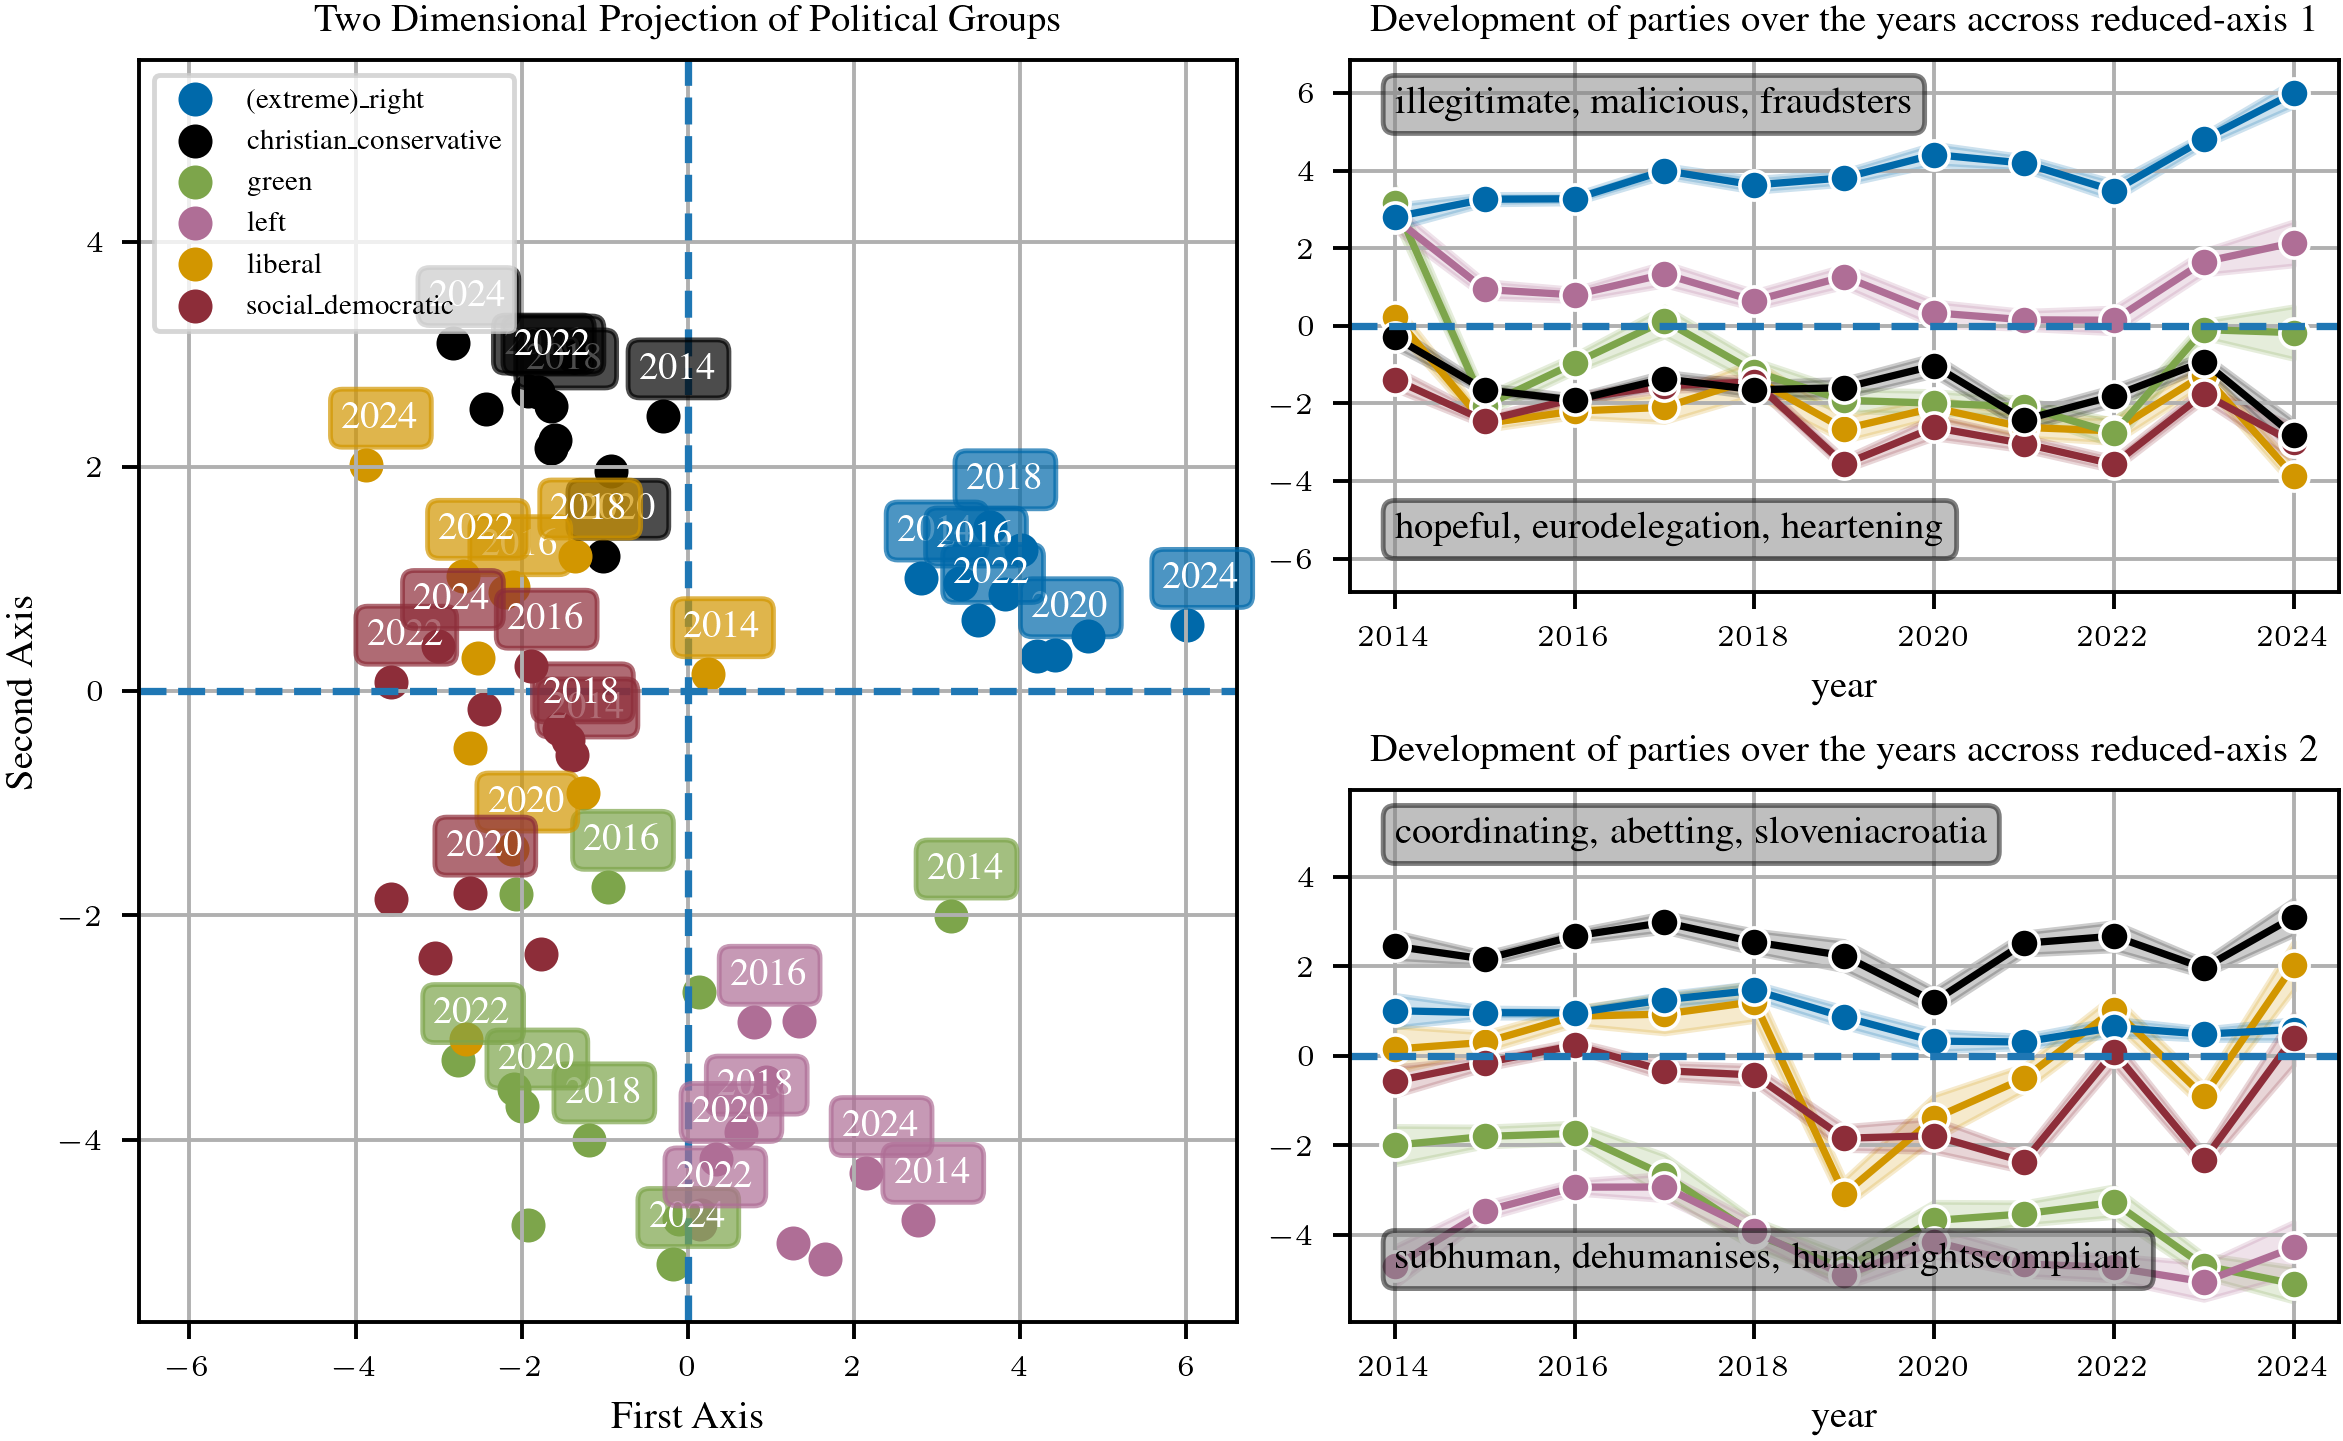

In [ ]:
from tueplots import bundles

params = bundles.icml2024(nrows=1,ncols=1, column="full") # if you need multiple columns / rows, change in your script
# params.update({"figure.dpi": 350})
plt.rcParams.update(params)

display_results(combined, pls_ref, [0, 1], aggregated, vocab_df, 
                #np.array(mapped_centers).mean(axis=0),
                 pls_ref.transform(np.stack(aggregated[EMBEDDING_MODEL])), "block", COLOR_MAPS['block'])

<Axes: xlabel='year', ylabel='reduced_0'>

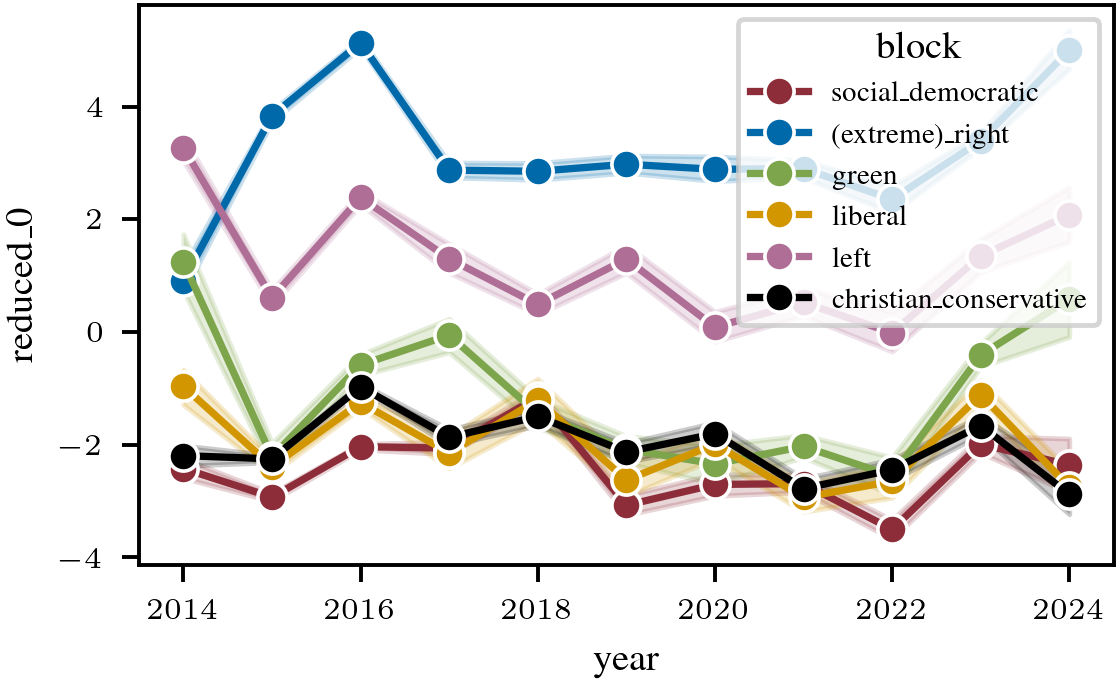

In [ ]:
sns.lineplot(data=combined.iloc[66:], x='year', y='reduced_0', hue='block', marker='o', palette=COLOR_MAPS['block'], errorbar="ci")

<Axes: xlabel='year', ylabel='reduced_1'>

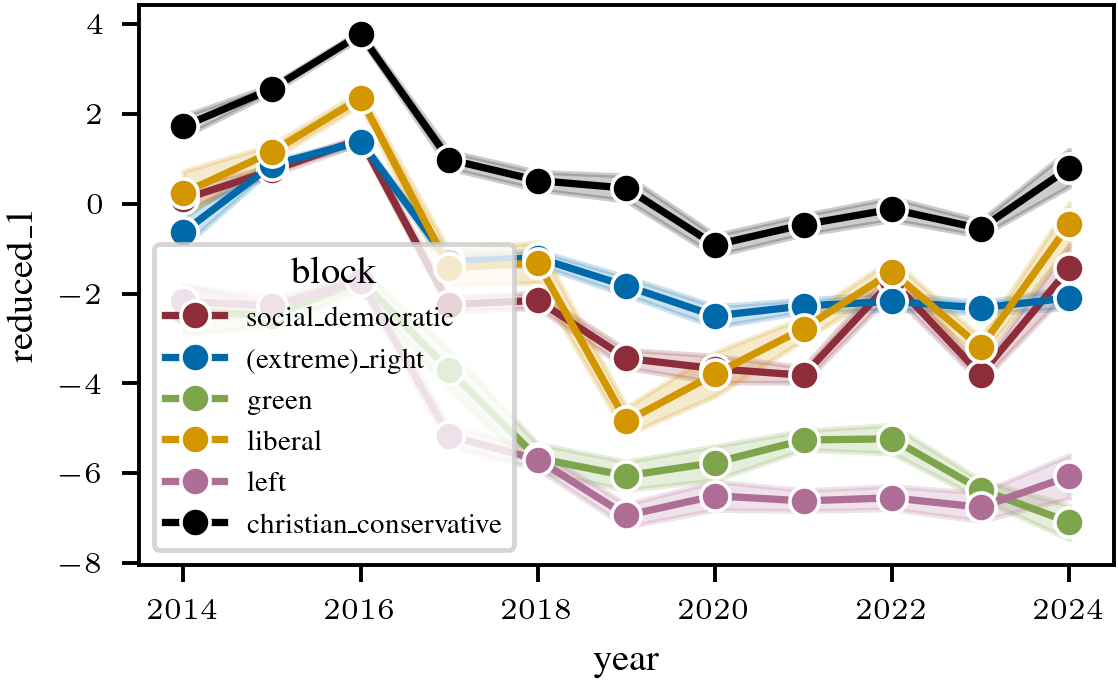

In [ ]:
sns.lineplot(data=combined.iloc[66:], x='year', y='reduced_1', hue='block', marker='o', palette=COLOR_MAPS['block'], errorbar="ci")

## Bootstrapping

### Bootstrap equal year block partitions

In [ ]:
N = df.groupby(["year", "block"]).size().min()
N_BOOTS = 10_000

def sample_from_df() -> pd.DataFrame: 
    dfs = []
    for block in df['block'].unique(): 
        for year in df['year'].unique(): 
            s = df[(df['year'] == year) & (df['block'] == block)]
            s = s.sample(N, replace=True)
            dfs.append(s)
    return pd.concat(dfs)

N

np.int64(9)

In [ ]:
from tqdm import tqdm
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

X = np.stack(df[EMBEDDING_MODEL])

W_whole, (pls_ref, _) = plsda(X, df['block'])

reduced_ref = pls_ref.transform(np.stack(aggregated[EMBEDDING_MODEL]))


angles = []
mapped_centers = []


for _ in tqdm(range(N_BOOTS)):
    df_sample = sample_from_df()
    X_sub = np.stack(df_sample[EMBEDDING_MODEL])
    y_sub = df_sample['block']
    W_sub, (pls, lb) = plsda(X_sub, y_sub)

    total_angle = sum(subspace_angles(W_whole, W_sub))

    reduced_sub = pls.transform(np.stack(aggregated[EMBEDDING_MODEL]))
    mapped_centers.append(align_vectors(reduced_sub, reduced_ref))

    angles.append(total_angle)


100%|██████████| 10000/10000 [09:28<00:00, 17.58it/s]


In [ ]:
plotting_data = aggregated[['block', 'year']].copy()
plotting_data['reduced_0'] = reduced_ref[:, 0]
plotting_data['reduced_1'] = reduced_ref[:, 1]
combined = plotting_data.copy()


for  embs in  tqdm(mapped_centers):
    coppied = plotting_data.copy()
    coppied[f'reduced_0'] = embs[:, 0]
    coppied[f'reduced_1'] = embs[:, 1]
    combined =  pd.concat([combined, coppied])

100%|██████████| 10000/10000 [00:30<00:00, 331.02it/s]


In [ ]:
combined.groupby(["block", "year"])['reduced_0'].std()

block              year
(extreme)_right    2014    0.383801
                   2015    0.421212
                   2016    0.563096
                   2017    0.336938
                   2018    0.345151
                             ...   
social_democratic  2020    0.355510
                   2021    0.325474
                   2022    0.354525
                   2023    0.368780
                   2024    0.437901
Name: reduced_0, Length: 66, dtype: float64

In [ ]:
combined['reduced_0'].mean()

np.float64(-0.011219813283052377)

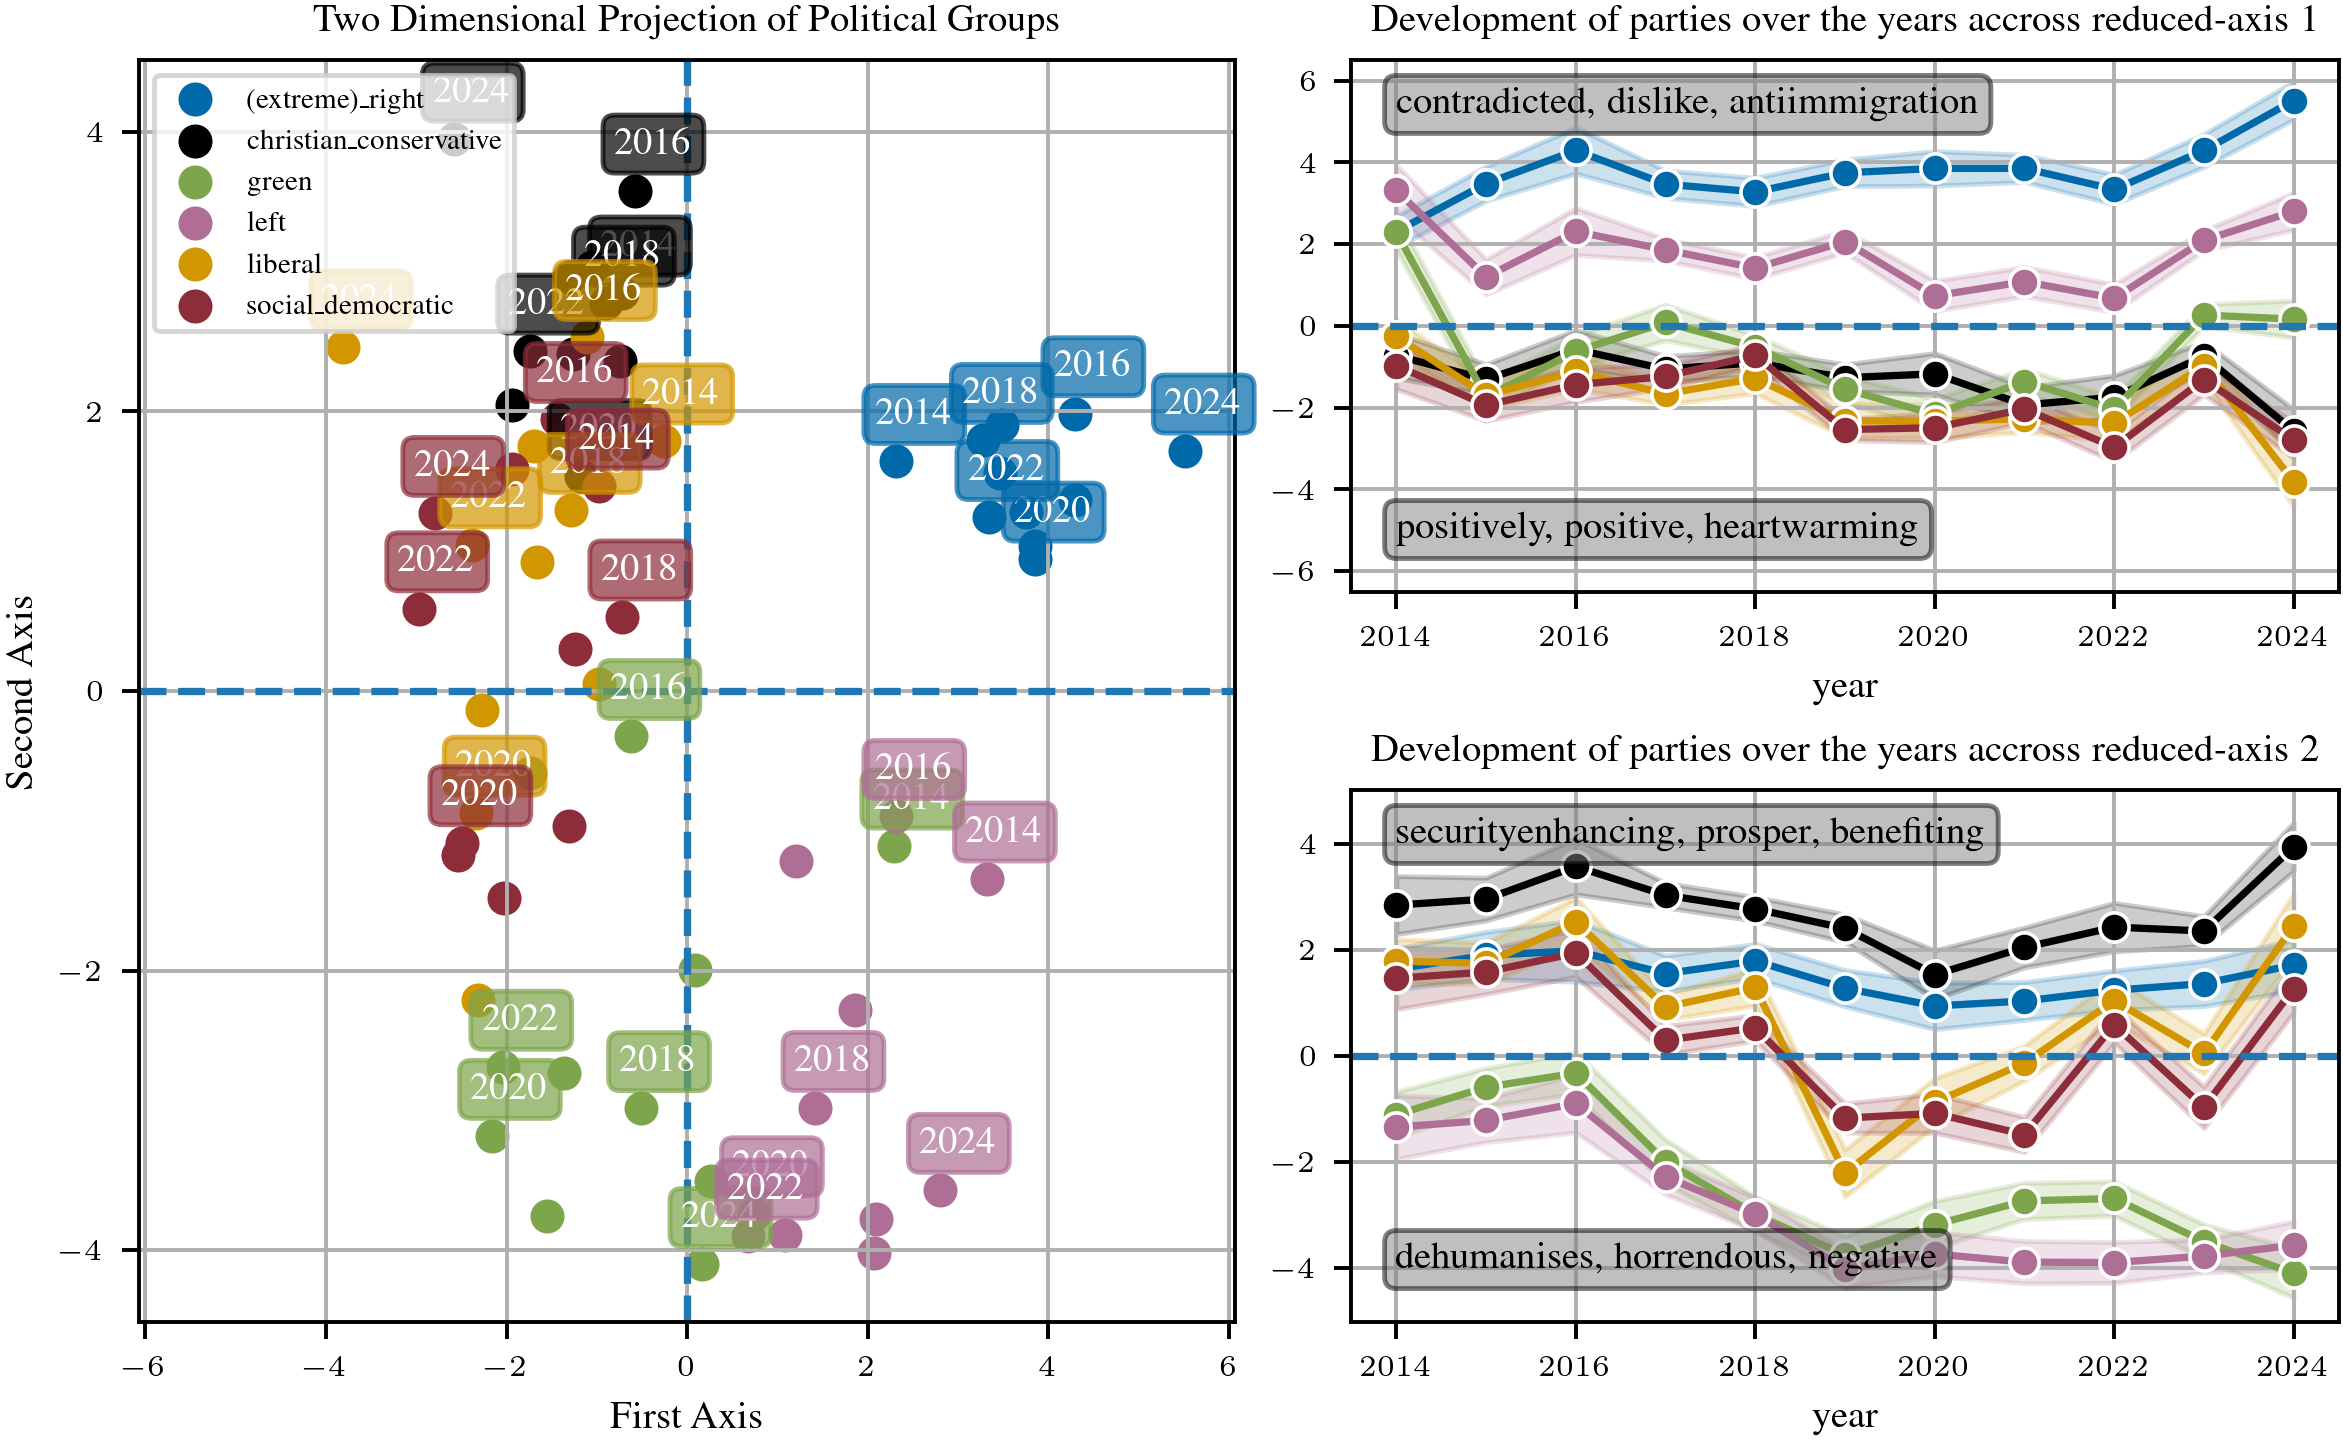

In [ ]:
display_results(combined, pls_ref, [0, 1], aggregated, vocab_df, 
                np.array(mapped_centers).mean(axis=0), "block", COLOR_MAPS['block'])

### Bootstrap equal amount of data from each year

In [ ]:
N = df.groupby(["year"]).size().min()
N_BOOTS = 10_000

def sample_from_df() -> pd.DataFrame: 
    dfs = []
    for year in df['year'].unique(): 
        s = df[(df['year'] == year)]
        s = s.sample(N, replace=True)
        dfs.append(s)
    return pd.concat(dfs)

N

np.int64(104)

In [ ]:
from tqdm import tqdm
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_MODEL, 'block')

X = np.stack(df[EMBEDDING_MODEL])

W_whole, (pls_ref, _) = plsda(X, df['block'])

reduced_ref = pls_ref.transform(np.stack(aggregated[EMBEDDING_MODEL]))


angles = []
mapped_centers = []


for _ in tqdm(range(N_BOOTS)):
    df_sample = sample_from_df()
    X_sub = np.stack(df_sample[EMBEDDING_MODEL])
    y_sub = df_sample['block']
    W_sub, (pls, lb) = plsda(X_sub, y_sub)

    total_angle = sum(subspace_angles(W_whole, W_sub))

    reduced_sub = pls.transform(np.stack(aggregated[EMBEDDING_MODEL]))
    mapped_centers.append(align_vectors(reduced_sub, reduced_ref))

    angles.append(total_angle)


100%|██████████| 10000/10000 [03:22<00:00, 49.46it/s]


In [ ]:
plotting_data = aggregated[['block', 'year']].copy()
plotting_data['reduced_0'] = reduced_ref[:, 0]
plotting_data['reduced_1'] = reduced_ref[:, 1]
combined = plotting_data.copy()


for  embs in  tqdm(mapped_centers):
    coppied = plotting_data.copy()
    coppied[f'reduced_0'] = embs[:, 0]
    coppied[f'reduced_1'] = embs[:, 1]
    combined =  pd.concat([combined, coppied])

100%|██████████| 10000/10000 [00:27<00:00, 369.80it/s]


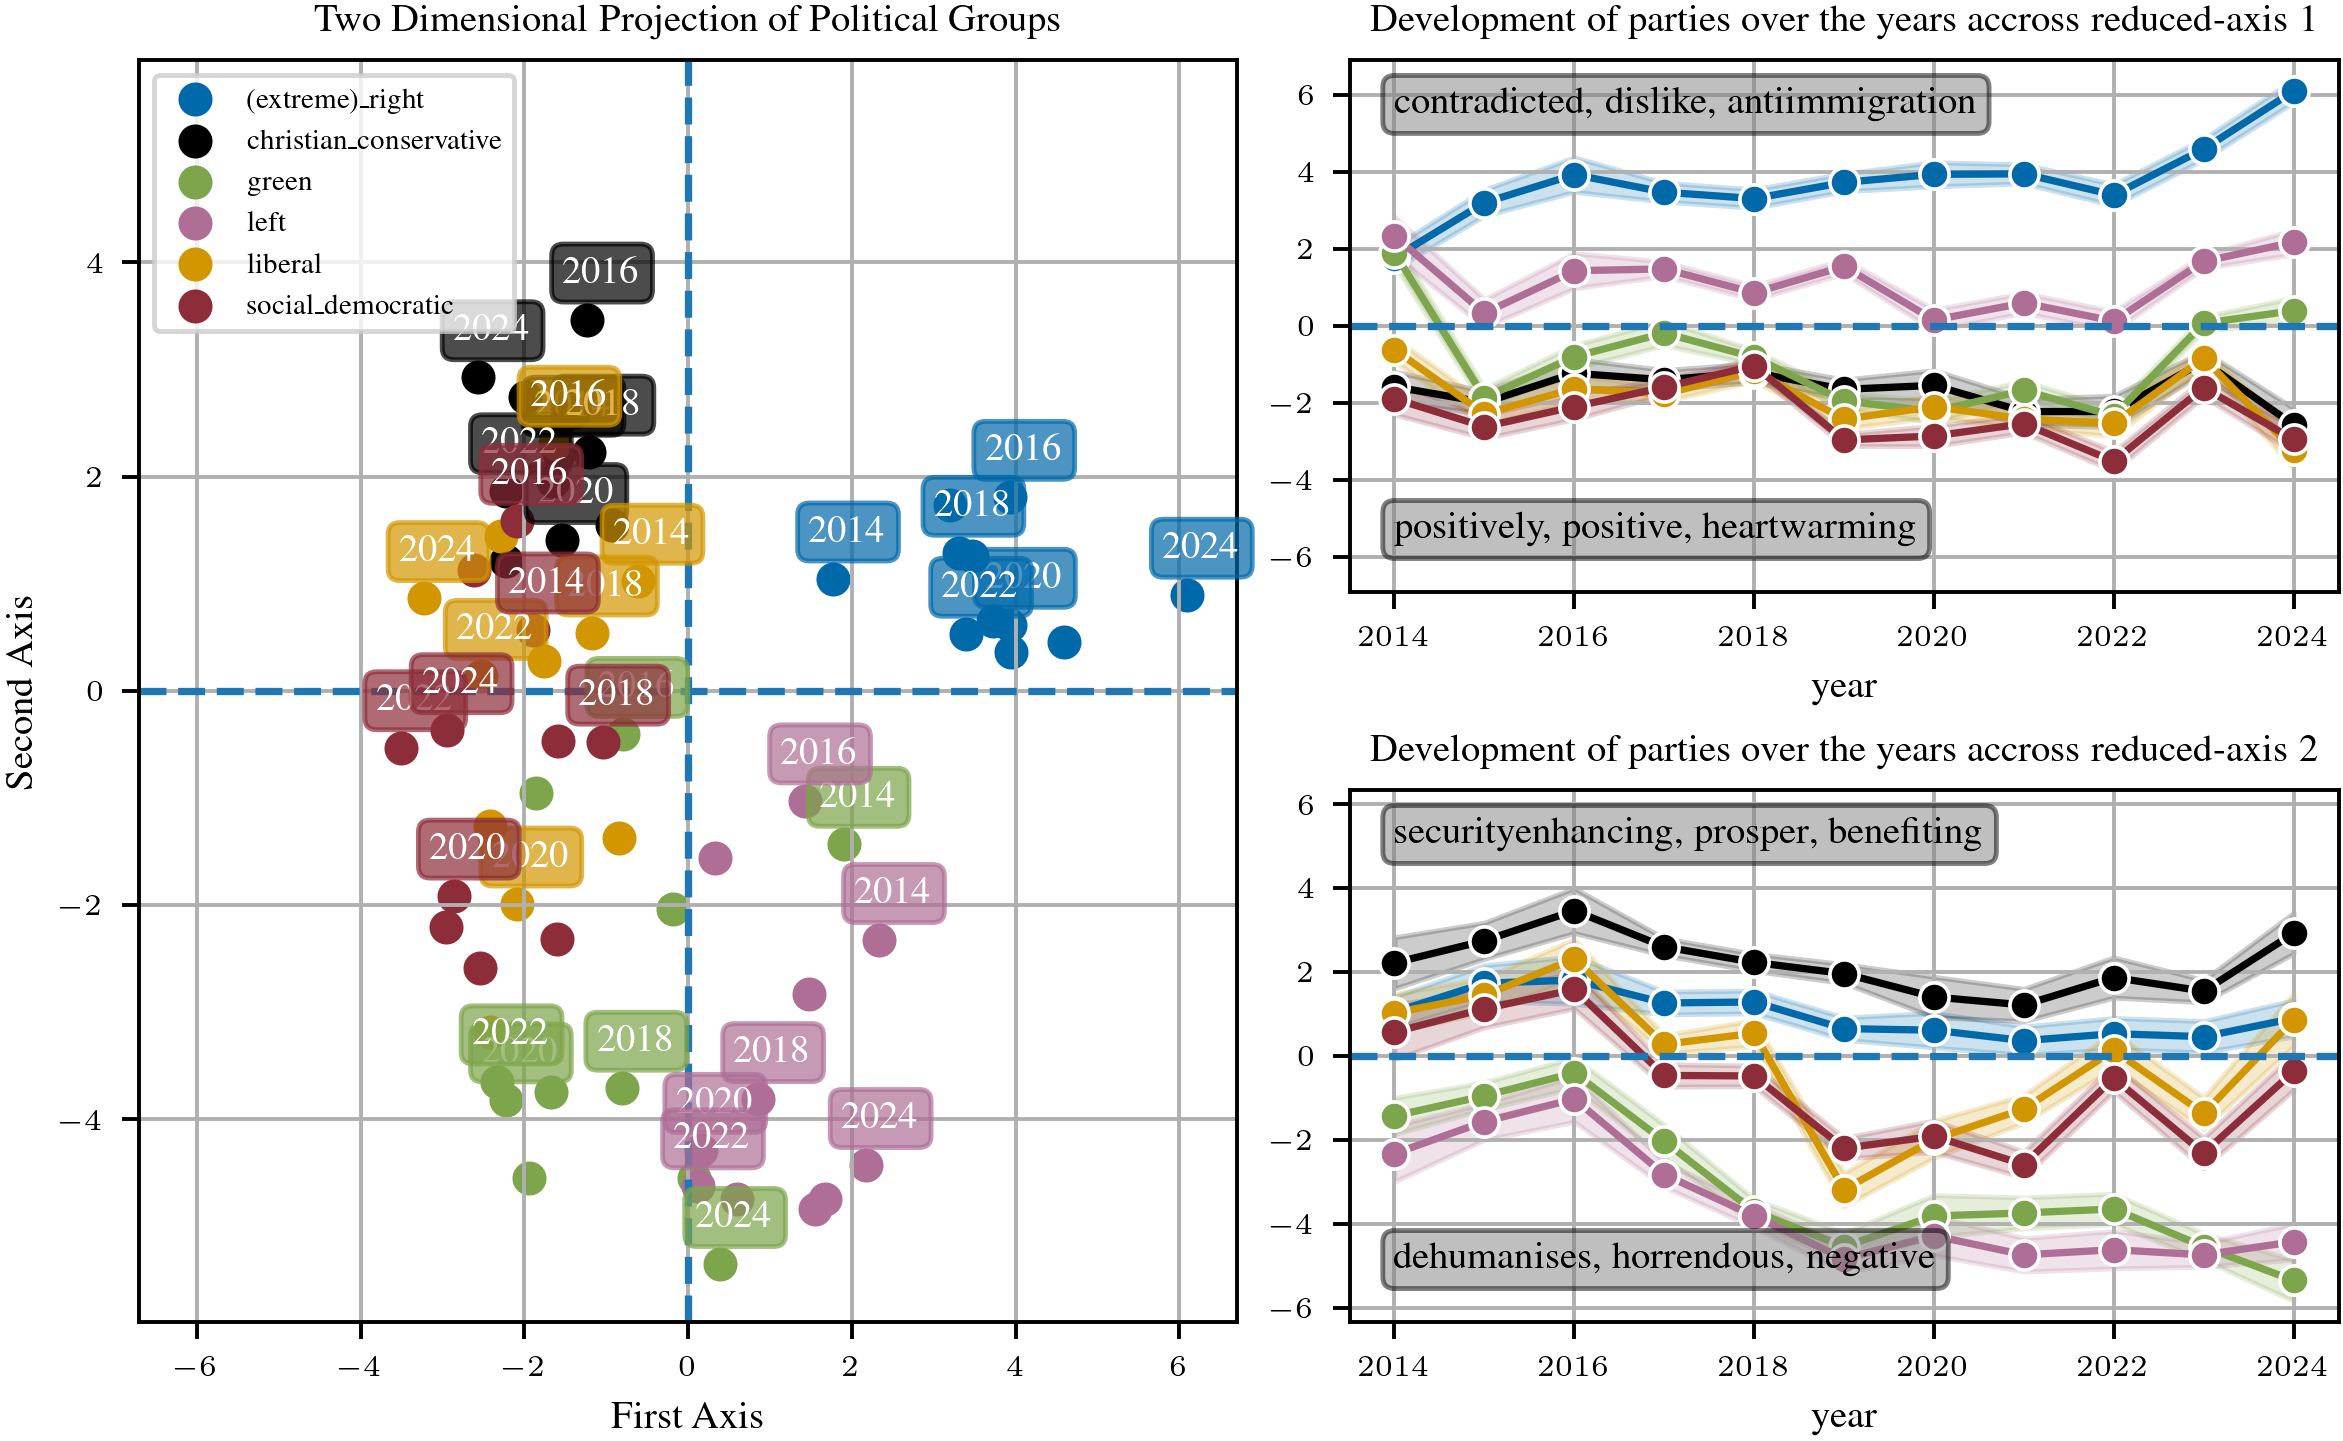

In [ ]:
display_results(combined, pls_ref, [0, 1], aggregated, vocab_df, 
                np.array(mapped_centers).mean(axis=0), "block", COLOR_MAPS['block'])